In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, confusion_matrix, accuracy_score

from catboost import CatBoostClassifier
import matplotlib.pyplot as plt


In [45]:

import pandas as pd
# import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, CatBoostClassifier

In [46]:
data = pd.read_csv('data/financial_data.csv', index_col=0)
data = data.drop(['price_to_sales', 'target'], axis=1)
data = data.dropna()

data_groups = pd.read_csv('data/S&P500-Info.csv', index_col=0)
merged = data.merge(data_groups[['Symbol', 'GICS Sector']], left_index=True, right_on='Symbol')
X = merged.drop('Symbol', axis=1).drop(['regression_target', 'SP_target'], axis=1)
target_reg = merged.regression_target
target_class = merged.SP_target * 1

In [47]:
X_train_df, X_test_df, y_train_reg, y_test_reg = train_test_split(X, target_reg.values, test_size=0.3, random_state=42)
_, _, y_train_class, y_test_class = train_test_split(X, target_class.values, test_size=0.3, random_state=42)

In [48]:
X_train = X_train_df.groupby('GICS Sector').transform(lambda x: (x - x.mean()) / x.std())
X_test_mean = X_test_df.merge(X_train_df.groupby('GICS Sector').mean(), left_on='GICS Sector', right_index=True)
X_test_mean_std = X_test_mean.merge(X_train_df.groupby('GICS Sector').std(), left_on='GICS Sector', right_index=True)
X_test_mean_std = X_test_mean_std.drop('GICS Sector', axis=1)
X_test = (X_test_mean_std.iloc[:, :9].values - X_test_mean_std.iloc[:, 9:18].values)/X_test_mean_std.iloc[:, 18:]

## 3. Применение SHAP

### 3.1. Сравнить важность признаков, получаемую с помощью SHAP с важностью признаков, получаемую с помощью модели на основе ансамбля деревьев решений. Прокомментировать результат (Есть ли разница? Можете ли вы это объяснить?). 

In [101]:
CB_model = CatBoostClassifier(learning_rate=1e-4, depth=3, random_seed=42)
CB_model.fit(X_train, y_train_class, verbose=False)
pred = CB_model.predict(X_test)

In [102]:
X = pd.concat([X_train, X_test]) 
y = np.concatenate([y_train_class, y_test_class])

In [103]:
X = X.reset_index(drop=True)

In [52]:
# важность признаков SHAP

In [104]:
import shap
from catboost import Pool

explainer = shap.TreeExplainer(CB_model)
shap_values = explainer.shap_values(Pool(X, y))

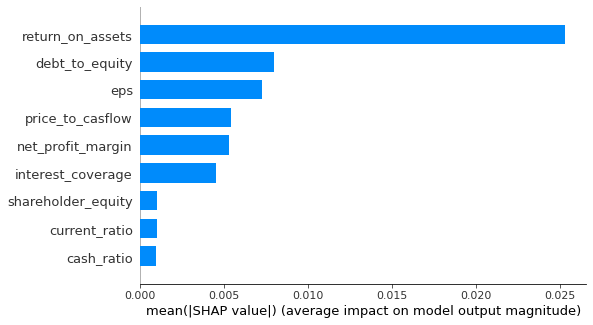

In [105]:
shap.summary_plot(shap_values, X, plot_type="bar")

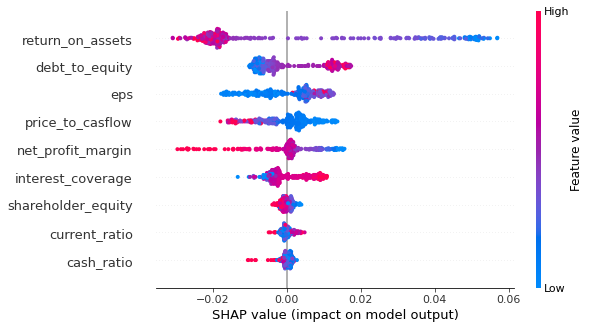

In [106]:
shap.summary_plot(shap_values, X)

In [56]:
# важность признаков на основе ансамбля деревьев

In [107]:
pd.DataFrame(CB_model.get_feature_importance(prettified=True)).head(20)

,Feature Id,Importances
0,return_on_assets,37.281580
1,eps,12.925771
2,net_profit_margin,11.342015
3,debt_to_equity,10.573310
4,price_to_casflow,10.412142
5,interest_coverage,6.133038
6,current_ratio,4.255519
7,shareholder_equity,3.606240
8,cash_ratio,3.470384


__Вывод__: разница есть, т.к. важности признаков строятся по разным методикам. 

    В первом случае - это SHAP values. Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (например, для каждого клиента в выборке) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи. 

    Во-втором случае, взят для примера встроенный метод get_feature_importance от реализации градиентного бустинга catboost. Он показывает для каждой i-ой фичи насколько меняется предсказание модели при изменении важности признака. 

### 3.2. Среди 3 методов, выбрать один, который обеспечивает наилучшее качества решения. Проанализировать SHAP-values для всего набора данных в целом. Меняется ли существенно важность признаков внутри класса и между классами? Какие признаки наиболее важны?

In [110]:
shap.initjs()

In [109]:
shap.force_plot(explainer.expected_value, shap_values, X)

__Вывод:__ Наиболее широкие красные фрагменты в начале графика и наиболее широкие синие в конце показывают, какие признаки вносят наибольший вклад в два класса. Мы видим, что положительный вклад вносят в основном такие признакие как ROA, а отрицательные - price_to_cashflow

### 3.3. Для того же метода, что и в вопросе выше, выбрать 2 примера из разных классов, где модель дает правильный ответ, и 2 примера из разных классов, где модель ошибается. Проанализировать эти примеры для всех 3 моделей с помощью SHAP. Похожи ли объяснения? (Внимание: 4 картинки * 3 модели = 12 примеров).

In [59]:
df_full = X.copy()
df_full['y_pred'] = CB_model.predict(X)
df_full['y_pred_proba'] = CB_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

In [60]:
df_full.head()

,debt_to_equity,current_ratio,cash_ratio,return_on_assets,eps,price_to_casflow,shareholder_equity,interest_coverage,net_profit_margin,y_pred,y_pred_proba,y_true
0,-0.058664,0.062880,-0.278166,0.423497,0.330525,2.811967,0.638116,0.014439,0.372865,1,0.506583,1
1,4.840815,-0.820426,-0.427122,0.049725,0.196237,-0.205543,-1.081221,0.244289,-0.117257,1,0.511125,0
2,0.023873,-0.789428,-0.351349,-1.149992,0.154927,-0.205610,-0.582956,0.270670,-1.125962,1,0.526625,1
3,-0.223837,-0.153447,-0.505887,-0.108256,-0.332992,-0.605507,-0.327450,0.243661,-0.318146,1,0.504976,0
4,0.142296,-0.977748,-0.673773,0.884381,0.213255,0.195786,-1.970890,0.164358,0.336564,1,0.505828,0


### Catboost model

In [92]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values.values[ind])

In [62]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

In [65]:
# initjs()

In [66]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

In [67]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(explainer.expected_value,shap_values[ind])

__Вывод:__ по отдельным примерам видно, как признаки из топа SHAP-values влияют на предсказание модели. Например, в случае, где модель проставила правильно класс 0, feature 4 (EPS) "тянет" пример к классу 0. Это видно и на суммарном графике summary_plot, где чем ниже EPS, тем более это склоняет пример к классу 0. Аналогично с классом 1, где высокое значение EPS тянет пример к классу 1.

### LogisticRegression

In [68]:
LR_model = LogisticRegression(penalty='l2', random_state=42)
LR_model.fit(X, y)


df_full['y_pred'] = LR_model.predict(X)
df_full['y_pred_proba'] = LR_model.predict_proba(X)[:, 1]
df_full['y_true'] = y

In [69]:
explainer = shap.Explainer(LR_model, X)
shap_values = explainer(X)

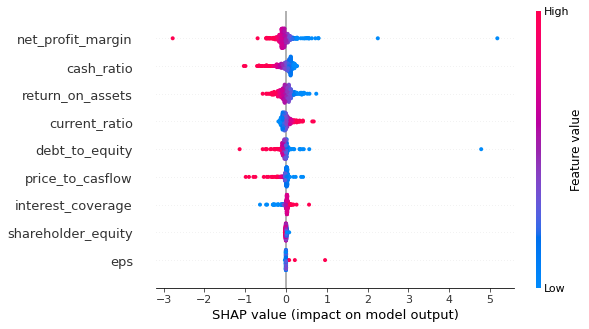

In [70]:
shap.summary_plot(shap_values, X)

In [71]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [72]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [73]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [74]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

__Вывод:__ качество модели хуже, чем у градиентного бустинга, поэтому на общем summary_plot видно, как плохо признаки разделяют примеры на классы. По конкретным примерам видно, например, что высокие значения Current_ratio склоняют примеры к классу 1, а низкие наоборот.

### SGDClassifier

In [75]:
SGDClassifier_model = SGDClassifier(loss='perceptron', penalty='l2', random_state=42)
SGDClassifier_model.fit(X_train, y_train_class)


df_full['y_pred'] = SGDClassifier_model.predict(X)
df_full['y_true'] = y

In [76]:
explainer = shap.Explainer(SGDClassifier_model, X)
shap_values = explainer(X)

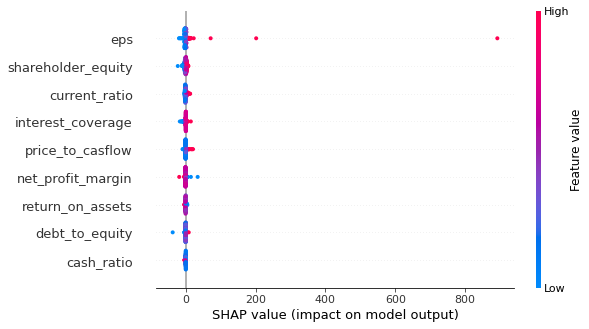

In [77]:
shap.summary_plot(shap_values, X)

In [78]:
# класс 0, модель правильно ответила

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.force_plot(shap_values[ind])

In [79]:
# класс 1, модель правильно ответила

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']==df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [80]:
# класс 0, модель ошиблась

ind = df_full[(df_full['y_true']==0)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

In [81]:
# класс 1, модель ошиблась

ind = df_full[(df_full['y_true']==1)
    &(df_full['y_true']!=df_full['y_pred'])].sample(1).index[0]

shap.plots.force(shap_values[ind])

__Вывод:__ эта модель показало еще более худшее качество, поэтому и по SHAP values на общем графике виден низкий вклад разных фичей и сильный разброс на конкретных примерах.